<a href="https://colab.research.google.com/github/dla9944/2023_God_damn_deeplearning/blob/master/Tacos%26Burrito_image_%EC%B2%98%EB%A6%AC_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# pytorch 라이브러리
import torch
import torchvision
import torch.nn.functional as F
from torch.utils import data
from torch import nn, optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import utils
# 시각화 관련

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm 

# arange 기본
import numpy as np
import pandas as pd

# image convertor
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 그외

import os
import random
import tqdm

In [2]:
# gpu 사용

USE_CUDA = torch.cuda.is_available()
device= torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using Device : {device}")
from sklearn.datasets import load_digits
digits = load_digits()

Using Device : cuda


# Reference 

https://github.com/lucidfrontier45

https://github.com/lucidfrontier45/PyTorch-Book

### 일본의 데이터 사이언스 전문인력 lucidfrontier45 님


In [ ]:
# 타코와 부리또 구분 처리

!wget https://github.com/lucidfrontier45/PyTorch-Book/raw/master/data/taco_and_burrito.tar.gz
!tar -zxvf taco_and_burrito.tar.gz


In [4]:
# dataset 작성
train_imgs = ImageFolder('/content/taco_and_burrito/train/',
                         transform = transforms.Compose([
                             transforms.RandomCrop(224),
                             transforms.ToTensor()
                         ]))
test_imgs = ImageFolder('/content/taco_and_burrito/test/',
                         transform = transforms.Compose([
                             transforms.RandomCrop(224),
                             transforms.ToTensor()
                         ]))

train_loader = DataLoader(train_imgs, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_imgs, batch_size = 32, shuffle = False)

In [5]:
print(train_imgs.classes), print(train_imgs.class_to_idx)

['burrito', 'taco']
{'burrito': 0, 'taco': 1}


(None, None)

(3, 896, 1792)


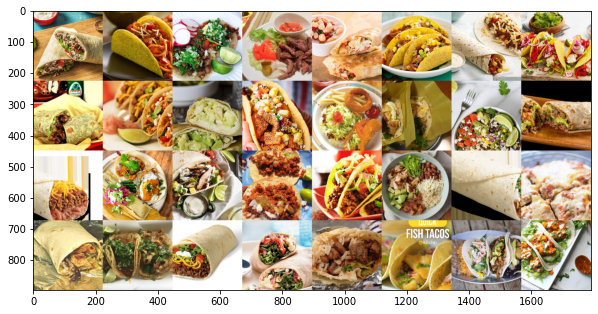

In [6]:
# 학습 데이터 확인
# 타코(위가 뚫려 있음), 브리또 (위가 막혀있음) 혼합 배출
dataiter = iter(train_loader)
images, labels = next(dataiter)
img = utils.make_grid(images, padding=0)
npimg = img.numpy()
print(npimg.shape)
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [16]:
# Resnet 미리 저장된 모델을 로드

net = models.resnet18(pretrained = True)

for p in net.parameters():
    p.requires_grad = False

# 마지막 계층만 변경
fc_input_dim = net.fc.in_features
net.fc = nn.Linear(fc_input_dim, 2)

In [17]:
# 모델 훈련 함수 제작

def eval_net(net, data_loader, device = device):
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            _, y_pred = net(x).max(1)
            ys.append(y)
            ypreds.append(y_pred)
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)

    accuracy = (ys == ypreds).float().sum()/len(ys)
    return accuracy.item()

def train_net(net, train_loader, test_loader, only_fc = True,
              optimizer = optim.Adam, loss_function = nn.CrossEntropyLoss(),
              n_iter = 10, device = device):
    train_losses = []
    train_accuracy = []
    val_accuracy = []
    if only_fc:
       optimizer = optimizer(net.fc.parameters())
    else: # 마지막 선형 계층의 패러미터만 optimizer 전달
       optimizer = optimizer(net.parameters())
    for epoch in range(n_iter):
        running_loss = 0.0
        net.train()
        n = 0
        n_accuracy = 0
        for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader), total = len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            h = net(xx)
            loss = loss_function(h, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n = n + len(xx)
            _, y_pred = h.max(1)
            n_accuracy += (yy == y_pred).float().sum().item()
        train_losses.append(running_loss / i)
        train_accuracy.append(n_accuracy / n)

        val_accuracy.append(eval_net(net, test_loader, device))

        print(f'epoch 횟수 = {epoch}, 학습 loss = {train_losses[-1]:.4f}, 학습 정확도 = {train_accuracy[-1]:.4f},검증 정확도 = {val_accuracy[-1]:.4f}',
              flush = True)

In [18]:
net.to(device)

# gpu에서 훈련 시작. EPOCH 20회
train_net(net, train_loader, test_loader, n_iter = 20, device = device)


100%|██████████| 23/23 [00:02<00:00,  9.32it/s]


epoch 횟수 = 0, 학습 loss = 0.7576, 학습 정확도 = 0.5562,검증 정확도 = 0.6167


100%|██████████| 23/23 [00:02<00:00,  9.64it/s]


epoch 횟수 = 1, 학습 loss = 0.6051, 학습 정확도 = 0.6868,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.49it/s]


epoch 횟수 = 2, 학습 loss = 0.5161, 학습 정확도 = 0.7753,검증 정확도 = 0.8167


100%|██████████| 23/23 [00:02<00:00,  9.53it/s]


epoch 횟수 = 3, 학습 loss = 0.4661, 학습 정확도 = 0.8132,검증 정확도 = 0.8000


100%|██████████| 23/23 [00:02<00:00,  9.42it/s]


epoch 횟수 = 4, 학습 loss = 0.4222, 학습 정확도 = 0.8357,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  8.69it/s]


epoch 횟수 = 5, 학습 loss = 0.4083, 학습 정확도 = 0.8427,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:04<00:00,  4.68it/s]


epoch 횟수 = 6, 학습 loss = 0.4016, 학습 정확도 = 0.8343,검증 정확도 = 0.8167


100%|██████████| 23/23 [00:03<00:00,  6.03it/s]


epoch 횟수 = 7, 학습 loss = 0.3774, 학습 정확도 = 0.8497,검증 정확도 = 0.8167


100%|██████████| 23/23 [00:02<00:00,  7.98it/s]


epoch 횟수 = 8, 학습 loss = 0.3452, 학습 정확도 = 0.8722,검증 정확도 = 0.7833


100%|██████████| 23/23 [00:02<00:00,  8.73it/s]


epoch 횟수 = 9, 학습 loss = 0.3422, 학습 정확도 = 0.8652,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.32it/s]


epoch 횟수 = 10, 학습 loss = 0.3570, 학습 정확도 = 0.8652,검증 정확도 = 0.8000


100%|██████████| 23/23 [00:02<00:00,  9.44it/s]


epoch 횟수 = 11, 학습 loss = 0.3712, 학습 정확도 = 0.8441,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  8.62it/s]


epoch 횟수 = 12, 학습 loss = 0.3441, 학습 정확도 = 0.8666,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:03<00:00,  6.90it/s]


epoch 횟수 = 13, 학습 loss = 0.3615, 학습 정확도 = 0.8385,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.39it/s]


epoch 횟수 = 14, 학습 loss = 0.3157, 학습 정확도 = 0.8764,검증 정확도 = 0.9167


100%|██████████| 23/23 [00:02<00:00,  9.50it/s]


epoch 횟수 = 15, 학습 loss = 0.3328, 학습 정확도 = 0.8722,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.43it/s]


epoch 횟수 = 16, 학습 loss = 0.3581, 학습 정확도 = 0.8483,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.41it/s]


epoch 횟수 = 17, 학습 loss = 0.3100, 학습 정확도 = 0.8736,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.50it/s]


epoch 횟수 = 18, 학습 loss = 0.3772, 학습 정확도 = 0.8581,검증 정확도 = 0.8167


100%|██████████| 23/23 [00:02<00:00,  9.46it/s]


epoch 횟수 = 19, 학습 loss = 0.3106, 학습 정확도 = 0.8610,검증 정확도 = 0.8333


In [19]:
net.to(device)

# gpu에서 훈련 시작. EPOCH 50회
train_net(net, train_loader, test_loader, n_iter = 50, device = device)


100%|██████████| 23/23 [00:02<00:00,  9.58it/s]


epoch 횟수 = 0, 학습 loss = 0.3431, 학습 정확도 = 0.8539,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.42it/s]


epoch 횟수 = 1, 학습 loss = 0.3201, 학습 정확도 = 0.8947,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.50it/s]


epoch 횟수 = 2, 학습 loss = 0.2949, 학습 정확도 = 0.8778,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.69it/s]


epoch 횟수 = 3, 학습 loss = 0.2880, 학습 정확도 = 0.8820,검증 정확도 = 0.8167


100%|██████████| 23/23 [00:02<00:00,  9.43it/s]


epoch 횟수 = 4, 학습 loss = 0.2836, 학습 정확도 = 0.8778,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.41it/s]


epoch 횟수 = 5, 학습 loss = 0.2942, 학습 정확도 = 0.8820,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.63it/s]


epoch 횟수 = 6, 학습 loss = 0.2851, 학습 정확도 = 0.8862,검증 정확도 = 0.8167


100%|██████████| 23/23 [00:02<00:00,  9.71it/s]


epoch 횟수 = 7, 학습 loss = 0.2886, 학습 정확도 = 0.8890,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.47it/s]


epoch 횟수 = 8, 학습 loss = 0.3021, 학습 정확도 = 0.8820,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.42it/s]


epoch 횟수 = 9, 학습 loss = 0.2935, 학습 정확도 = 0.8862,검증 정확도 = 0.8167


100%|██████████| 23/23 [00:02<00:00,  9.58it/s]


epoch 횟수 = 10, 학습 loss = 0.2861, 학습 정확도 = 0.8876,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.73it/s]


epoch 횟수 = 11, 학습 loss = 0.2856, 학습 정확도 = 0.8947,검증 정확도 = 0.7833


100%|██████████| 23/23 [00:02<00:00,  9.22it/s]


epoch 횟수 = 12, 학습 loss = 0.2711, 학습 정확도 = 0.8890,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.57it/s]


epoch 횟수 = 13, 학습 loss = 0.2549, 학습 정확도 = 0.9073,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.33it/s]


epoch 횟수 = 14, 학습 loss = 0.2942, 학습 정확도 = 0.8764,검증 정확도 = 0.9167


100%|██████████| 23/23 [00:02<00:00,  9.63it/s]


epoch 횟수 = 15, 학습 loss = 0.2918, 학습 정확도 = 0.8666,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.44it/s]


epoch 횟수 = 16, 학습 loss = 0.2865, 학습 정확도 = 0.8834,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.41it/s]


epoch 횟수 = 17, 학습 loss = 0.2789, 학습 정확도 = 0.8919,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.48it/s]


epoch 횟수 = 18, 학습 loss = 0.2912, 학습 정확도 = 0.8792,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.45it/s]


epoch 횟수 = 19, 학습 loss = 0.2820, 학습 정확도 = 0.8834,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  8.97it/s]


epoch 횟수 = 20, 학습 loss = 0.3003, 학습 정확도 = 0.8708,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:03<00:00,  7.58it/s]


epoch 횟수 = 21, 학습 loss = 0.2865, 학습 정확도 = 0.8862,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.39it/s]


epoch 횟수 = 22, 학습 loss = 0.2698, 학습 정확도 = 0.8933,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.14it/s]


epoch 횟수 = 23, 학습 loss = 0.2773, 학습 정확도 = 0.8890,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.33it/s]


epoch 횟수 = 24, 학습 loss = 0.2708, 학습 정확도 = 0.8989,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.20it/s]


epoch 횟수 = 25, 학습 loss = 0.2718, 학습 정확도 = 0.8834,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.41it/s]


epoch 횟수 = 26, 학습 loss = 0.2590, 학습 정확도 = 0.8904,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.37it/s]


epoch 횟수 = 27, 학습 loss = 0.2825, 학습 정확도 = 0.8806,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.27it/s]


epoch 횟수 = 28, 학습 loss = 0.2683, 학습 정확도 = 0.8890,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.45it/s]


epoch 횟수 = 29, 학습 loss = 0.2726, 학습 정확도 = 0.8947,검증 정확도 = 0.8167


100%|██████████| 23/23 [00:02<00:00,  9.36it/s]


epoch 횟수 = 30, 학습 loss = 0.2787, 학습 정확도 = 0.9059,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.17it/s]


epoch 횟수 = 31, 학습 loss = 0.2608, 학습 정확도 = 0.8933,검증 정확도 = 0.7500


100%|██████████| 23/23 [00:02<00:00,  9.30it/s]


epoch 횟수 = 32, 학습 loss = 0.2728, 학습 정확도 = 0.8947,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.47it/s]


epoch 횟수 = 33, 학습 loss = 0.2635, 학습 정확도 = 0.8933,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.30it/s]


epoch 횟수 = 34, 학습 loss = 0.2445, 학습 정확도 = 0.9143,검증 정확도 = 0.7667


100%|██████████| 23/23 [00:02<00:00,  9.33it/s]


epoch 횟수 = 35, 학습 loss = 0.2834, 학습 정확도 = 0.8947,검증 정확도 = 0.9167


100%|██████████| 23/23 [00:02<00:00,  9.27it/s]


epoch 횟수 = 36, 학습 loss = 0.2427, 학습 정확도 = 0.9059,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.62it/s]


epoch 횟수 = 37, 학습 loss = 0.2784, 학습 정확도 = 0.8736,검증 정확도 = 0.8167


100%|██████████| 23/23 [00:02<00:00,  9.50it/s]


epoch 횟수 = 38, 학습 loss = 0.2934, 학습 정확도 = 0.9059,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.37it/s]


epoch 횟수 = 39, 학습 loss = 0.2880, 학습 정확도 = 0.8736,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.39it/s]


epoch 횟수 = 40, 학습 loss = 0.2831, 학습 정확도 = 0.8947,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  8.63it/s]


epoch 횟수 = 41, 학습 loss = 0.2965, 학습 정확도 = 0.8750,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  8.49it/s]


epoch 횟수 = 42, 학습 loss = 0.2733, 학습 정확도 = 0.8876,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.39it/s]


epoch 횟수 = 43, 학습 loss = 0.2893, 학습 정확도 = 0.8947,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.36it/s]


epoch 횟수 = 44, 학습 loss = 0.2685, 학습 정확도 = 0.8778,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.67it/s]


epoch 횟수 = 45, 학습 loss = 0.2888, 학습 정확도 = 0.8919,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.47it/s]


epoch 횟수 = 46, 학습 loss = 0.2372, 학습 정확도 = 0.9101,검증 정확도 = 0.8167


100%|██████████| 23/23 [00:02<00:00,  9.38it/s]


epoch 횟수 = 47, 학습 loss = 0.2751, 학습 정확도 = 0.8947,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.52it/s]


epoch 횟수 = 48, 학습 loss = 0.2511, 학습 정확도 = 0.8933,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.53it/s]


epoch 횟수 = 49, 학습 loss = 0.2399, 학습 정확도 = 0.9101,검증 정확도 = 0.8167


In [20]:
# 입력을 그대로 출력해서 더미 계층을 만들어 fc를 변경

class FlattenLayer(nn.Module):
   def forward(self, x):
       sizes = x.size()
       return x.view(sizes[0], -1)

class IdentityLayer(nn.Module):
   def forward(self, x):
       return x

In [21]:
net = models.resnet18(pretrained = True)
for p in net.parameters():
    p.requires_grad = False
net.fc = IdentityLayer()

In [12]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# CNN 신경망 새롭게 정의
cnn_NET = nn.Sequential(
    nn.Conv2d(3, 32, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    FlattenLayer()
)

test_input = torch.ones(1, 3, 224, 224)
conv_output_size = cnn_NET(test_input).size()[-1]

net = nn.Sequential(
    cnn_NET,
    nn.Linear(conv_output_size, 2)
)

In [22]:
# 학습 EPOCH 20회
net.to(device)
train_net(net, train_loader, test_loader, n_iter = 20, only_fc = False,
          device = device)

100%|██████████| 23/23 [00:03<00:00,  7.47it/s]


epoch 횟수 = 0, 학습 loss = 3.8341, 학습 정확도 = 0.5955,검증 정확도 = 0.5333


100%|██████████| 23/23 [00:02<00:00,  7.74it/s]


epoch 횟수 = 1, 학습 loss = 5.4181, 학습 정확도 = 0.6067,검증 정확도 = 0.6167


100%|██████████| 23/23 [00:03<00:00,  7.64it/s]


epoch 횟수 = 2, 학습 loss = 5.1026, 학습 정확도 = 0.6376,검증 정확도 = 0.6833


100%|██████████| 23/23 [00:02<00:00,  7.73it/s]


epoch 횟수 = 3, 학습 loss = 4.0106, 학습 정확도 = 0.6770,검증 정확도 = 0.6167


100%|██████████| 23/23 [00:02<00:00,  7.73it/s]


epoch 횟수 = 4, 학습 loss = 4.4809, 학습 정확도 = 0.6250,검증 정확도 = 0.5833


100%|██████████| 23/23 [00:02<00:00,  7.74it/s]


epoch 횟수 = 5, 학습 loss = 4.1884, 학습 정확도 = 0.6489,검증 정확도 = 0.5833


100%|██████████| 23/23 [00:02<00:00,  7.77it/s]


epoch 횟수 = 6, 학습 loss = 4.1639, 학습 정확도 = 0.6728,검증 정확도 = 0.5000


100%|██████████| 23/23 [00:02<00:00,  7.71it/s]


epoch 횟수 = 7, 학습 loss = 5.7483, 학습 정확도 = 0.6180,검증 정확도 = 0.6833


100%|██████████| 23/23 [00:03<00:00,  7.17it/s]


epoch 횟수 = 8, 학습 loss = 6.0919, 학습 정확도 = 0.6334,검증 정확도 = 0.6500


100%|██████████| 23/23 [00:04<00:00,  5.01it/s]


epoch 횟수 = 9, 학습 loss = 6.3512, 학습 정확도 = 0.6798,검증 정확도 = 0.6333


100%|██████████| 23/23 [00:03<00:00,  7.10it/s]


epoch 횟수 = 10, 학습 loss = 4.7981, 학습 정확도 = 0.6292,검증 정확도 = 0.5500


100%|██████████| 23/23 [00:02<00:00,  7.86it/s]


epoch 횟수 = 11, 학습 loss = 4.7414, 학습 정확도 = 0.6629,검증 정확도 = 0.5833


100%|██████████| 23/23 [00:02<00:00,  7.84it/s]


epoch 횟수 = 12, 학습 loss = 4.0677, 학습 정확도 = 0.6756,검증 정확도 = 0.6000


100%|██████████| 23/23 [00:03<00:00,  6.97it/s]


epoch 횟수 = 13, 학습 loss = 5.1967, 학습 정확도 = 0.6433,검증 정확도 = 0.7167


100%|██████████| 23/23 [00:03<00:00,  6.50it/s]


epoch 횟수 = 14, 학습 loss = 4.2844, 학습 정확도 = 0.7079,검증 정확도 = 0.7167


100%|██████████| 23/23 [00:02<00:00,  7.79it/s]


epoch 횟수 = 15, 학습 loss = 5.1129, 학습 정확도 = 0.6699,검증 정확도 = 0.6667


100%|██████████| 23/23 [00:04<00:00,  5.73it/s]


epoch 횟수 = 16, 학습 loss = 4.5866, 학습 정확도 = 0.6784,검증 정확도 = 0.6167


100%|██████████| 23/23 [00:02<00:00,  7.71it/s]


epoch 횟수 = 17, 학습 loss = 3.9064, 학습 정확도 = 0.6910,검증 정확도 = 0.5833


100%|██████████| 23/23 [00:02<00:00,  7.72it/s]


epoch 횟수 = 18, 학습 loss = 3.6993, 학습 정확도 = 0.6798,검증 정확도 = 0.7333


100%|██████████| 23/23 [00:02<00:00,  7.74it/s]


epoch 횟수 = 19, 학습 loss = 3.9458, 학습 정확도 = 0.7121,검증 정확도 = 0.7167


In [ ]:
# 학습 EPOCH 50회 (예정)
net.to(device)
train_net(net, train_loader, test_loader, n_iter = 20, only_fc = False,
          device = device)

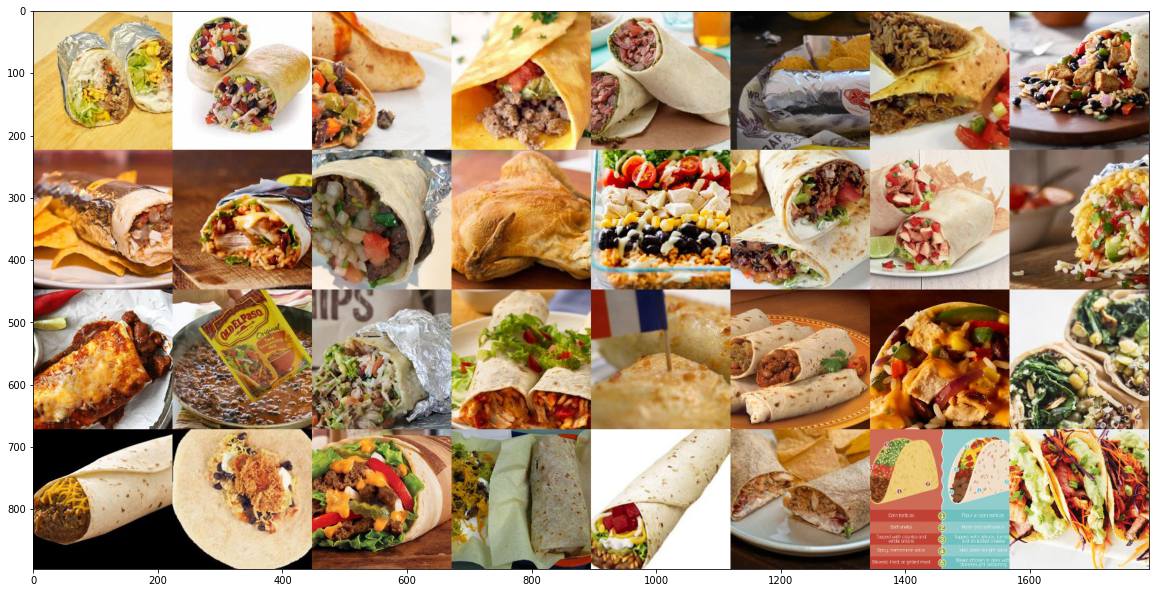

In [14]:
# 테스트 데이터 
# 브리또 배출(위가 막혀있음)
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = utils.make_grid(images, padding=0)
npimg = img.numpy()

plt.figure(figsize=(20, 14))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()